In [38]:
import pandas as pd
import numpy as np

In [39]:
data = pd.read_excel('../data/final_data.xlsx')

# choose class
data = data[data['Classe Vela'] == '49erFX']

In [28]:
# create dictionary to map competitor names to unique indices
competitor_to_index = {competitor: idx for idx, competitor in enumerate(data['Nome Competidor'].unique())}

# create matrix of size (n_players, n_players) with zeros
n_players = len(competitor_to_index)
matrix_alpha = np.zeros((n_players, n_players))
matrix_beta = np.zeros((n_players, n_players))

# iterate through competitions
for competition in data['Nome Competição'].unique():
    # get data for this competition
    data_competition = data[data['Nome Competição'] == competition]
    data_competition = data_competition.drop_duplicates(subset='Nome Competidor', keep='first')

    # get list of competitors in this competition
    competitors = data_competition['Nome Competidor'].unique()
    # get number of competitors in this competition
    n_players = len(competitors)
    
    # iterate through competitors in this competition setting (i, j) = 1 if i beats j in this competition
    # get i and j from the dictionary
    for i in range(n_players):
        for j in range(n_players):
            competitor_i = competitors[i]
            competitor_j = competitors[j]
            posicao_i = data_competition[(data_competition['Nome Competidor'] == competitor_i)]['Posição Geral'].values[0]
            posicao_j = data_competition[(data_competition['Nome Competidor'] == competitor_j)]['Posição Geral'].values[0]
            pontuacao_i = data_competition[(data_competition['Nome Competidor'] == competitor_i)]['Pontuação Total'].values[0]
            pontuacao_j = data_competition[(data_competition['Nome Competidor'] == competitor_j)]['Pontuação Total'].values[0]

            # get index of competitor i and j in the matrix
            index_i = competitor_to_index[competitor_i]
            index_j = competitor_to_index[competitor_j]

            if posicao_i < posicao_j:
                # update the cumulative matrix
                matrix_alpha[index_i][index_j] += 1
                # update matrix beta with difference in points
                matrix_beta[index_i][index_j] += (pontuacao_i - pontuacao_j)/ pontuacao_i + pontuacao_j

In [29]:
#checking results
write_matrix = pd.DataFrame(matrix_alpha)

# columns and index are the names of the competitors
write_matrix.columns = competitor_to_index.keys()
write_matrix.index = competitor_to_index.keys()

In [30]:
write_matrix

,"MARTINE GRAEL, KAHENA KUNZE","IDA MARIE BAAD NIELSEN, MARIE THUSGAARD OLSEN","HANNA KLINGA, LISA ORN","ODILE VAN AANHOLT, ANNETTE DUETZ","MAIKEN FOGHT SCHUTT, ANNE-JULIE SCHUTT","ANNEMIEK BEKKERING, ANNETTE DUETZ","ANIKA LORENZ, VICTORIA JURCZOK","ODILE VAN AANHOLT, ELISE RUYTER","VILMA BOBECK, REBECCA NETZLER","RAGNA AGERUP, MAIA AGERUP",...,"MARINA TARAN, ANGELINA MARKOVA","YANG YIN, SHI SHIQING","GUO FAN, ZHOU YAN","ANASTASIA VORONKOVA, OLGA KNIPOVICH","MENGMENG ZHANG, XIAOYA SU","KATE SHANER, KATHLEEN LOVE","HUIJIA YU, YE JIN","KAMONCHANOK KLAHAN, NICHAPA WAIWAI","SHASHA CHEN, NANA HU","TINA LUTZ, LOTTA WIEMERS"
"MARTINE GRAEL, KAHENA KUNZE",0.0,6.0,3.0,2.0,2.0,4.0,8.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
"IDA MARIE BAAD NIELSEN, MARIE THUSGAARD OLSEN",2.0,0.0,3.0,0.0,2.0,4.0,7.0,0.0,0.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
"HANNA KLINGA, LISA ORN",1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ODILE VAN AANHOLT, ANNETTE DUETZ",4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"MAIKEN FOGHT SCHUTT, ANNE-JULIE SCHUTT",2.0,2.0,2.0,0.0,0.0,3.0,4.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"KATE SHANER, KATHLEEN LOVE",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
"HUIJIA YU, YE JIN",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
"KAMONCHANOK KLAHAN, NICHAPA WAIWAI",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"SHASHA CHEN, NANA HU",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
import networkx as nx
import matplotlib.pyplot as plt

# W = matrix_alpha
W = matrix_alpha

# add some perturbation to the matrix
perturbed_W = W + 0.00001 * np.ones(W.shape)

# define digraph W
G = nx.DiGraph(perturbed_W)

# check if G is strongly connected
nx.is_strongly_connected(G)

True

In [136]:
# Keener's ranking

# get d vector, d=(W + W^T)1, where 1 is a vector of ones 
d = np.dot(perturbed_W + perturbed_W.T, np.ones(perturbed_W.shape[0]))

# get D matrix, D = diag(d)
# we'll use D to normalize the matrix by the number of competitions each competitor was in
D = np.diag(d)

# perron frobeniun eigenvector of D^-1 W
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(D), perturbed_W))
# absolute value of eigenvalues
eigenvalues = np.abs(eigenvalues)
idx = np.argmax(eigenvalues)
eigenvector = eigenvectors[idx]

# absolute value of eigenvector
eigenvector = np.abs(eigenvector)

# get the ranking
ranking = pd.DataFrame(eigenvector, index=competitor_to_index.keys(), columns=['rating'])
ranking = ranking.sort_values(by='rating', ascending=False)
ranking

,rating
"MARTINE GRAEL, KAHENA KUNZE",1.526682e-01
"ODILE VAN AANHOLT, ANNETTE DUETZ",1.266952e-01
"CHARLOTTE DOBSON, SASKIA TIDEY",1.166354e-01
"ISAURA MAENHAUT, ANOUK GEURTS",1.140918e-01
"TAMARA ECHEGOYEN, BERTA BETANZOS",1.060141e-01
...,...
"CATHERINE BARTELHEIMER, DANIELA BARTELHEIMER",5.267883e-03
"FRANCESCA BERGAMO, ALICE SINNO",5.267883e-03
"HE XIAN, YU XUEBIN",5.046927e-03
"CRYSTAL SUN, OLIVIA HOBBS",5.046927e-03


In [137]:
# # draw the graph 15x10
# # make the dots small
# # make the edges thin

# plt.figure(figsize=(15,10))
# nx.draw(G, node_size=30, width=0.1)


In [138]:
# add column with row number
ranking['ranking'] = ranking.reset_index().index + 1
ranking

,rating,ranking
"MARTINE GRAEL, KAHENA KUNZE",1.526682e-01,1
"ODILE VAN AANHOLT, ANNETTE DUETZ",1.266952e-01,2
"CHARLOTTE DOBSON, SASKIA TIDEY",1.166354e-01,3
"ISAURA MAENHAUT, ANOUK GEURTS",1.140918e-01,4
"TAMARA ECHEGOYEN, BERTA BETANZOS",1.060141e-01,5
...,...,...
"CATHERINE BARTELHEIMER, DANIELA BARTELHEIMER",5.267883e-03,312
"FRANCESCA BERGAMO, ALICE SINNO",5.267883e-03,313
"HE XIAN, YU XUEBIN",5.046927e-03,314
"CRYSTAL SUN, OLIVIA HOBBS",5.046927e-03,315


In [95]:
# output each line of the ranking to a csv file in the format
# ranking, competitor, rating
for index, row in ranking.iterrows():
    print(str(int(row['ranking'])) + ', ' + index + ', ' + str(row['rating']))

1, MARTINE GRAEL, KAHENA KUNZE, 0.1526682216032501
2, ODILE VAN AANHOLT, ANNETTE DUETZ, 0.1266952412379301
3, CHARLOTTE DOBSON, SASKIA TIDEY, 0.11663543686356805
4, ISAURA MAENHAUT, ANOUK GEURTS, 0.1140917770363577
5, TAMARA ECHEGOYEN, BERTA BETANZOS, 0.10601407442250162
6, FRANCESCA CLAPCICH, GIULIA CONTI, 0.10601407442250162
7, MAIKEN FOGHT SCHUTT, ANNE-JULIE SCHUTT, 0.1026270670361164
8, ANNEMIEK BEKKERING, ANNETTE DUETZ, 0.1026270670361164
9, FREYA BLACK, SASKIA TIDEY, 0.10258585840133537
10, PATRICIA SUAREZ, MARIA CANTERO, 0.10258585840133537
11, ANIKA LORENZ, VICTORIA JURCZOK, 0.10235186274539547
12, ODILE VAN AANHOLT, ELISE RUYTER, 0.10235186274539547
13, HANNA KLINGA, LISA ORN, 0.09581316655374199
14, ODILE VAN AANHOLT, PHILIPINE VAN AANHOLT, 0.09209872331716065
15, ANNA LUSCHAN, JOHANNA DAUM, 0.09209872331716065
16, OLIVIA PRICE, EVIE HASELDINE, 0.09032523364076081
17, SOPHIE WEGUELIN, SOPHIE AINSWORTH, 0.09032523364076081
18, IDA MARIE BAAD NIELSEN, MARIE THUSGAARD OLSEN, 0.0

In [125]:
matrix_beta = np.nan_to_num(matrix_beta)
S = matrix_beta

# add some perturbation to the matrix
perturbed_S = S + np.ones(S.shape)

# define digraph S
G = nx.DiGraph(perturbed_S)

# check if G is strongly connected
nx.is_strongly_connected(G)

True

In [126]:
#checking results
write_matrix = pd.DataFrame(perturbed_S)

# columns and index are the names of the competitors
write_matrix.columns = competitor_to_index.keys()
write_matrix.index = competitor_to_index.keys()
write_matrix

,"MARTINE GRAEL, KAHENA KUNZE","IDA MARIE BAAD NIELSEN, MARIE THUSGAARD OLSEN","HANNA KLINGA, LISA ORN","ODILE VAN AANHOLT, ANNETTE DUETZ","MAIKEN FOGHT SCHUTT, ANNE-JULIE SCHUTT","ANNEMIEK BEKKERING, ANNETTE DUETZ","ANIKA LORENZ, VICTORIA JURCZOK","ODILE VAN AANHOLT, ELISE RUYTER","VILMA BOBECK, REBECCA NETZLER","RAGNA AGERUP, MAIA AGERUP",...,"MARINA TARAN, ANGELINA MARKOVA","YANG YIN, SHI SHIQING","GUO FAN, ZHOU YAN","ANASTASIA VORONKOVA, OLGA KNIPOVICH","MENGMENG ZHANG, XIAOYA SU","KATE SHANER, KATHLEEN LOVE","HUIJIA YU, YE JIN","KAMONCHANOK KLAHAN, NICHAPA WAIWAI","SHASHA CHEN, NANA HU","TINA LUTZ, LOTTA WIEMERS"
"MARTINE GRAEL, KAHENA KUNZE",1.000000,805.543416,487.840010,190.491937,297.155289,723.966596,1341.675150,1.0,306.276336,890.047454,...,1.0,1.0,1.0,1.0,315.606061,365.227273,371.181818,391.030303,490.272727,1.0
"IDA MARIE BAAD NIELSEN, MARIE THUSGAARD OLSEN",240.985993,1.000000,488.209772,1.000000,297.384645,787.378459,1317.162230,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,315.864865,365.527027,371.486486,391.351351,490.675676,1.0
"HANNA KLINGA, LISA ORN",88.093750,1.000000,1.000000,1.000000,167.969136,95.020833,612.519023,1.0,1.000000,559.583180,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
"ODILE VAN AANHOLT, ANNETTE DUETZ",569.368789,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,337.250423,1.000000,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
"MAIKEN FOGHT SCHUTT, ANNE-JULIE SCHUTT",243.418414,277.120140,325.583224,1.000000,1.000000,367.494989,724.857444,1.0,1.000000,744.135456,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"KATE SHANER, KATHLEEN LOVE",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.000000,1.000000,372.983607,392.928962,492.655738,1.0
"HUIJIA YU, YE JIN",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,392.946237,492.677419,1.0
"KAMONCHANOK KLAHAN, NICHAPA WAIWAI",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,492.744898,1.0
"SHASHA CHEN, NANA HU",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [134]:
# keener's ranking with beta matrix

# S = matrix_beta
perturbed_S = matrix_beta

# get d vector, d=(S + S^T)1, where 1 is a vector of ones
d = np.dot(perturbed_S + perturbed_S.T, np.ones(perturbed_S.shape[0]))

# get D matrix, D = diag(d)
D = np.diag(d)

# create empty K matrix with same size as matrix_beta
K = np.zeros(perturbed_S.shape)

# for entry (i, j) in beta matrix, define h = ((i, j) + 1)/((i, j) + (j, i) + 2)
for i in range(n_players):
    for j in range(n_players):
        x = (perturbed_S[i][j] + 1)/(perturbed_S[i][j] + perturbed_S[j][i] + 2)
        h = 1/2 + 1/2 * np.sign(x - 1/2) * np.sqrt(abs(2*x - 1))
        K[i][j] = h

# perron frobenius eigenvector of D^-1 K
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(D), K))
idx = np.argmax(eigenvalues)
eigenvector = eigenvectors[idx]

# get the ranking
ranking = pd.DataFrame(eigenvector, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)

ranking.head(30)

LinAlgError: Singular matrix

In [11]:
# maximum a posteriori ranking

# n = number of competitors
n = matrix_alpha.shape[0]

prior_mean = 0
prior_var = 1

posterior_mean = np.zeros(n)
posterior_var = np.zeros(n)

# iterate through competitors
for i in range(n):
    # likelihood mean
    likelihood_mean = np.sum(matrix_alpha[i])/(n-1)
    # likelihood variance
    likelihood_var = np.var(matrix_alpha[i])

    # posterior mean
    posterior_mean[i] = (likelihood_var * prior_mean + prior_var * likelihood_mean)/(prior_var + likelihood_var)
    # posterior variance
    posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)

# get the ranking
ranking = pd.DataFrame(posterior_mean, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)


C:\Users\Carol Erthal\AppData\Local\Temp\ipykernel_3884\1816485200.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)


In [12]:
ranking.head(30)

,ranking
Emma WILSON,0.962177
Shahar TIBI,0.920791
Sharon KANTOR,0.897159
Marta MAGGETTI,0.877488
Katy SPYCHAKOV,0.864681
Sara WENNEKES,0.862398
Maja DZIARNOWSKA,0.849109
Islay WATSON,0.834292
Veerle TEN HAVE,0.817533
Lola SORIN,0.810311


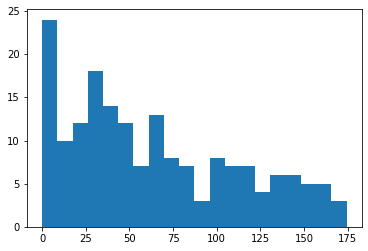

In [13]:
# sum line by line of matrix alpha and show histogram
sum = np.sum(matrix_alpha, axis=1)

# histogram of sum
import matplotlib.pyplot as plt
plt.hist(sum, bins=20)
plt.show()

In [15]:
# get mean and variance of sum
mean = np.mean(sum)
var = np.var(sum)

print(mean, var)

64.41340782122904 2354.23391085727


In [ ]:
# maximum a posteriori ranking
# for exponential prior

# n = number of competitors
n = matrix_alpha.shape[0]

prior_mean = 64
prior_var = 2354

posterior_mean = np.zeros(n)
posterior_var = np.zeros(n)

# iterate through competitors
for i in range(n):
    # likelihood mean
    likelihood_mean = np.sum(matrix_alpha[i])/(n-1)
    # likelihood variance
    likelihood_var = np.var(matrix_alpha[i])

    # posterior mean
    posterior_mean[i] = (likelihood_var * prior_mean + prior_var * likelihood_mean)/(prior_var + likelihood_var)
    # posterior variance
    posterior_var[i] = 1/(1/prior_var + 1/likelihood_var)

# get the ranking
ranking = pd.DataFrame(posterior_mean, index=competitor_to_index.keys(), columns=['ranking'])
ranking = ranking.sort_values(by='ranking', ascending=False)
